# RELAZIONE ESAME PYTHON "Esercizio Parameter Regression ML"

##  introduzione

Questa relazione ha l'obbiettivo di analizzare la relazione tra la Star-Formation-Rate-Density(SFRD) e 6 parametri  $ \vec{\theta}=\{ \Omega_m, \sigma_8,A_{SN1},A_{SN2},A_{AGNI1},A_{AGNI2}\}   $. In particolare,non verrà ricavato un modello analitico della Loro relazione ma sraà allenato un Newral Network per approssimare la funzione inversa : $$f^{-1}(SFRD(z))=\vec{\theta} $$

Questa relazione ha l'obbiettivo di riassumere e commentare i risultati principali del Newral Network creato nel file ['Huang_lorenzo_ML'](./Huang_lorenzo_ML.ipynb)

### dati
dati un set di 1000 simulazioni idrodinami che abbiamo a disposizione:
1. una vettore 2d di valori di SFRD su 100 punti  `z=np.linspace(0.0, 7.0, 100) `una per ogni simulazione, quindi sono 100000 numeri
2. un secondo set di vettore 2d di valori di $ \vec{\theta}=\{ \Omega_m, \sigma_8,A_{SN1},A_{SN2},A_{AGNI1},A_{AGNI2}\} $ utilizzati per la simulazione corrispondente

ecco un grafico delle prime 5 Simulazione e

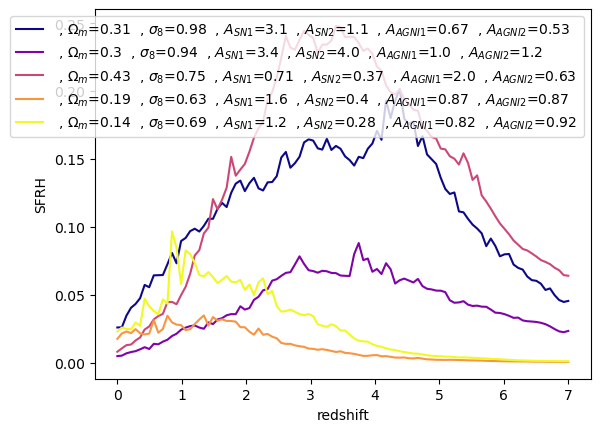

## Descrizione archittetura programma
il programma è formato da diverse sezioni, che si occhipano di diversi compiti, bisogna fare almeno 1 esecuzione dell'intero programma dopo di che, facendo uso del **content table**, quasi tutte le sezioni possono essere eseguite indipendentemente:

### sezione import librerie e dati 
questa sezione ha il compito di caricare tutte le librerie e dati necessari allo script, può subire leggere modifiche a seconda Enviroment su cui stai lavorando (conda o colab), è inoltre presente una cella di codice il cui unico compito è di controllare se tra i parametri dell'esperimento ci sono duplicati.


### sezione Definizione archittettura NN e Datasets

#### datasets
questa sezione di è dedicata alla definizione di funzioni che creano il dataset, modello NN, training dell'NN.

il dataset è creato attraverso 2 oggetti, la classe `class make_dataset()`, la funzione `create_dataset`, che separa i dati secondo le percentuali:
* 75% per **training**
* 15% per **validation**
* 15% per **test**

inolte le input x (SFRD) vengono normallizzate e le output y($\vec{θ}$) vengono standardizzatio attraverso i comandi forniti da np
```
        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y, axis=0)
        y = (y - mean)/std

```
inoltre in questa sezione è presente 1 print per assicurarsi che i dataset abbiano la dimesione giusta, poiche una forma erronea causa difetti nel training senza errori espliciti.
```
        print(self.input.shape,self.output.shape)
```

#### NN constructors
questa sezione definiscono le funzioni necessari alla costruzione del modello neural-network e del suo training ecco i punti salienti:

1. il `model_builder` è in grado solo di costruire Newral networks con la stessa funzione di attivazione, e numeri di neuroni per ogni strato

2. il `nn_training ` definiscre internamente il scheduler e optimizer
```
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-6)
```
3. la loss function è definito come una variabile esterna globale
4. nel file ['dimostrazione_che_il_codice_funziona'](./dimostrazione_che_il_codice_funziona.ipynb) è stato testato il funzionamento del Neural network su un'altro problema per confermare il corretto funzionamento dello script


### Optuna section
qui viene implementato optuna e i vari grafici
```
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.PercentilePruner(80.))
```
che cerca quindi di trovare i hyper-paramenter: lr=learning_rate, number_layers=numero di strati, hidden_size=numero neuroni, epochs=numero massimo di cicli su cui il training dura

### Best Parameter model section
questa sezione implementa un NN training con i parametri migliori trovati da Optuna e la parte del test sul test loader e vari grafici.

Di base non può essere eseguito senza eseguire prima la sezione con Optuna, almeno che non si inserisca manualmente i parametri migliori, in quelo caso questa sezione diventa un semplice Training del NN con i hyper_parameter scelti.


### Error
questa sezione si occupa dell'approssimazione dei parametri e i loro errori raddoppiando il numero di output da 6 $→$12  la prima metà dedicata ai parametri, la seconda metà dedicata alle loro variaze che sono.

L'approssimazione delle varianze è implementata attraverso la definizione di una nuova loss:
$$ Loss=\frac{log(∑_{batch}∑_{\vecθ}(θ_i-\hatθ_i)^2)+log(∑_{batch}∑_{\vecθ}((θ_i-\hatθ_i)^2-σ_i^2)^2)}{Batch\_size} $$

viene poi fatto un ottimizzazione con Optuna e praticamente ripetuto il punto precedente

## Risultati programma

### Variabili migliori secondo Optuna
per trovare le variabili migliori è stato fatto eseguire uno `study` su 100 `Trial` senza attivare mai il pruner `optuna.pruners.NopPruner()`, cosi ottenere immagine completa dell'influenza dei hyper parameters.

un risultato consistante tra tutte le esecuzioni di codice è che la 'min_valid_loss' non è mai minore di 0.5.

`min_valid_loss`≥0.5

qui sotto mostro vari grafici ottenuti da Optuna:

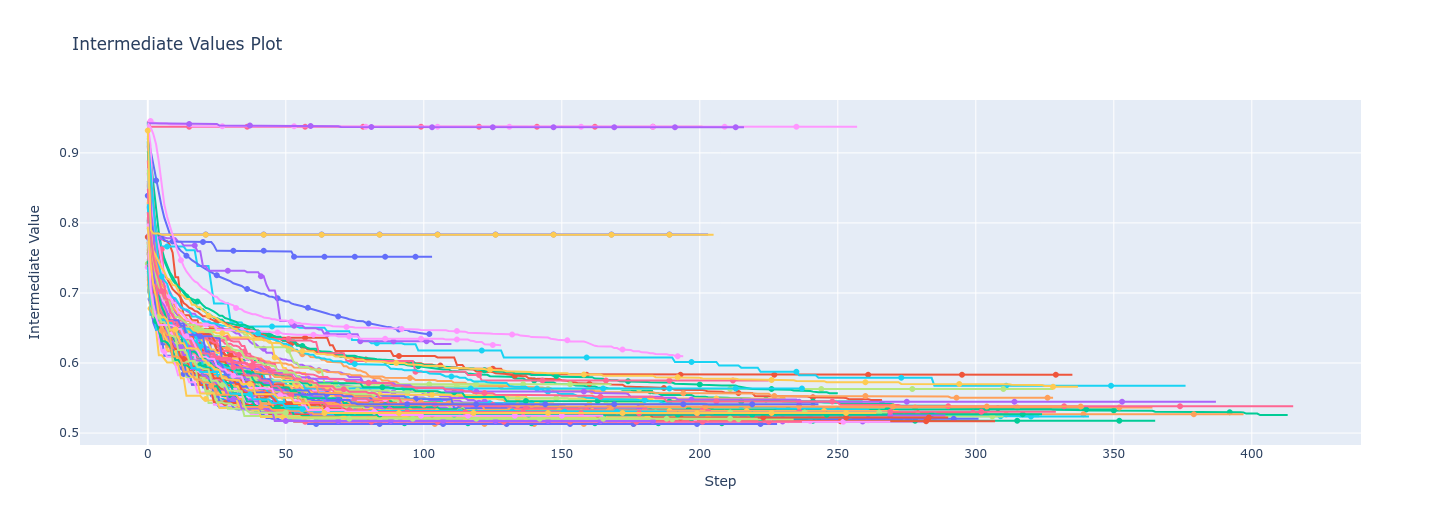

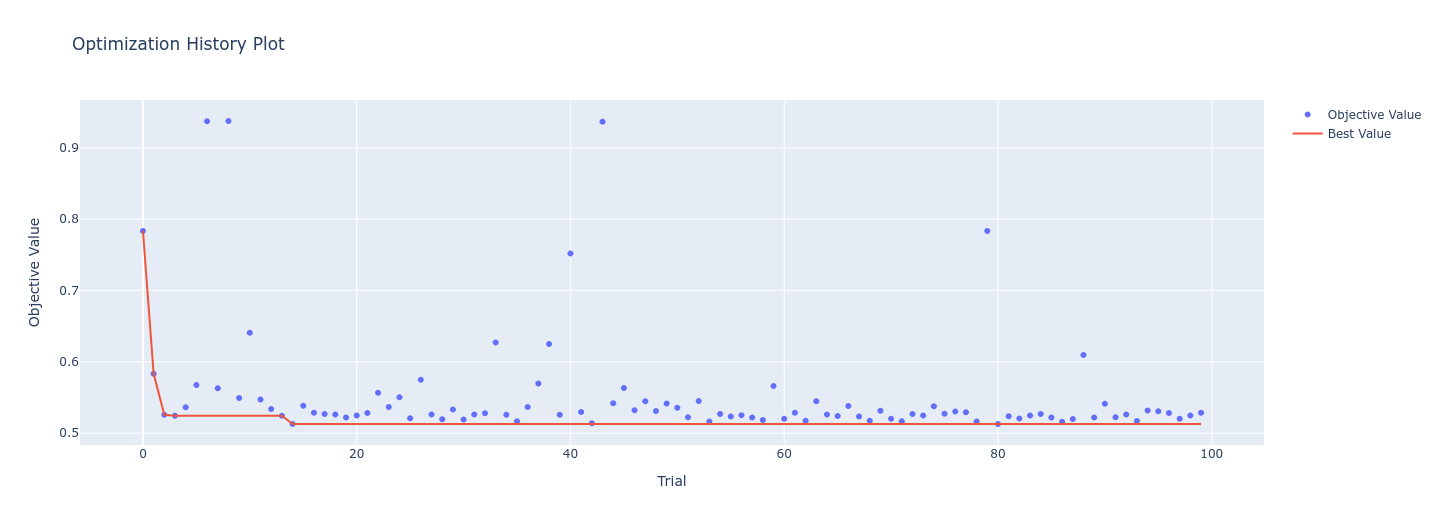

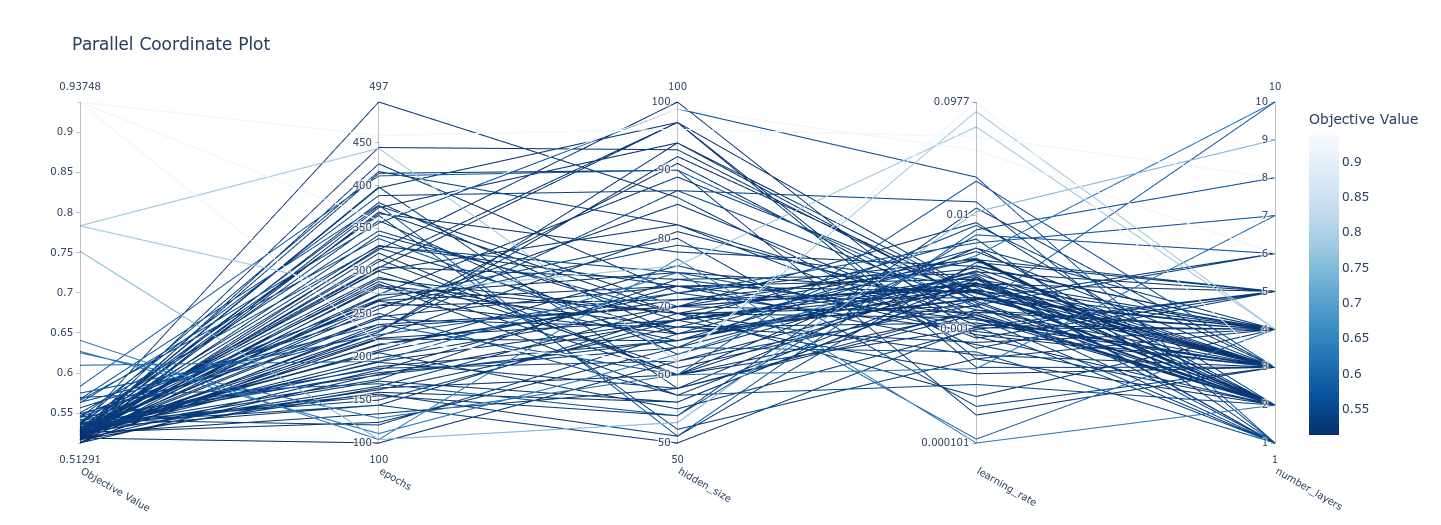

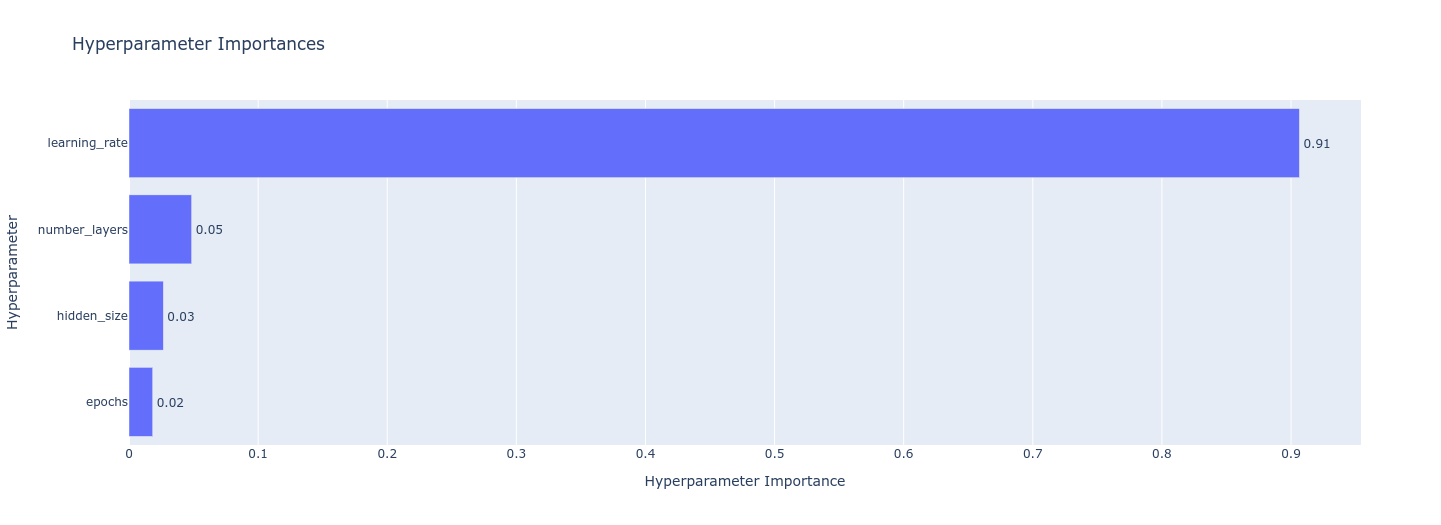

sembra quindi che la ` learning_rate ` sia il parametro più importante, questo parametro ha il compito di controllare di quanto cambiano i parametri nel ciclo di training.

I parametri migliori sono dell'ordine di $lr∼10^{-3}$, questo potrebbe essere dato dal fatto che poiche il NN ha 100 numeri come input e 6 numeri come output, la loss function varia molto anche per spostamenti piccoli, e quindi sia necessario una `lr` molto piccolo per minimizzare queste fluttuazioni e trovare il punto di minimo.

### Neural Network con la variabili migliori
il neural network è stato poi riallenato con i hyper-parameters migliori secondo optuna, invece di caricare il modello migliore secondo Optuna, perche se il modello mostra performance migliore su certi hyper-paramers questa deve essere una legge che vale in modo generico non solo su un istanza specifica del modello.
```
number_layers: 3
learning_rate: 0.0020637162736772967
epochs: 229
hidden_size: 92
```


qui segue il plot della train-loss e validations-loss in funzione delle epoche, fino alle `best_epoch`, come si vede la NN raggiunge velocemente il minimo, per poi bloccarsi ad un plateau e terminare il training perche la loss function non è migliorata dopo 200 epoche.

Questo è un fenomeno consistente nei training con i parametri migliori, probabilmente dato dal fatto che c'è una correlazione tra la "velocità" di un NN a raggiungere un plateau, e il minimo assoluto che raggiunge la `loss_function`. 

Questo spiega anche perche il parametro `epochs` non ha molta influenza nell'ottimizzazione: i modelli migliori terminano spesso il training per la `stop_criterion` non per aver terminato tutte i cicli

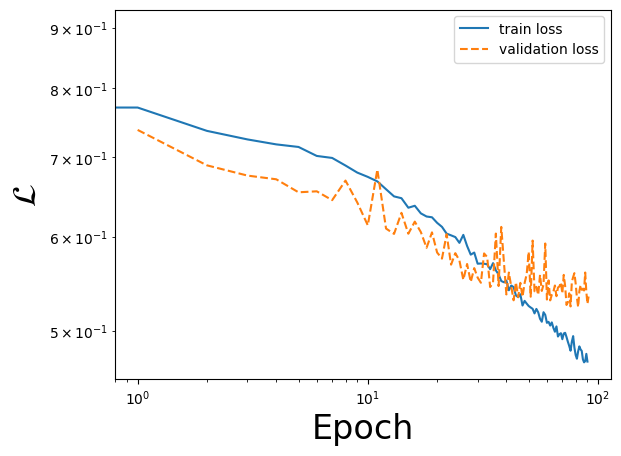

la parte del test sul `Train-loader` ha dato una uncome risultato
```
test loss = 5.950e-01
```

e in seguito lo scatterplot delle parametri del Neural Network rispetto a quelli veri, è inoltre stato plottato la retta $ f(x)=x $ per facilitare analisi di questi scatterplot.

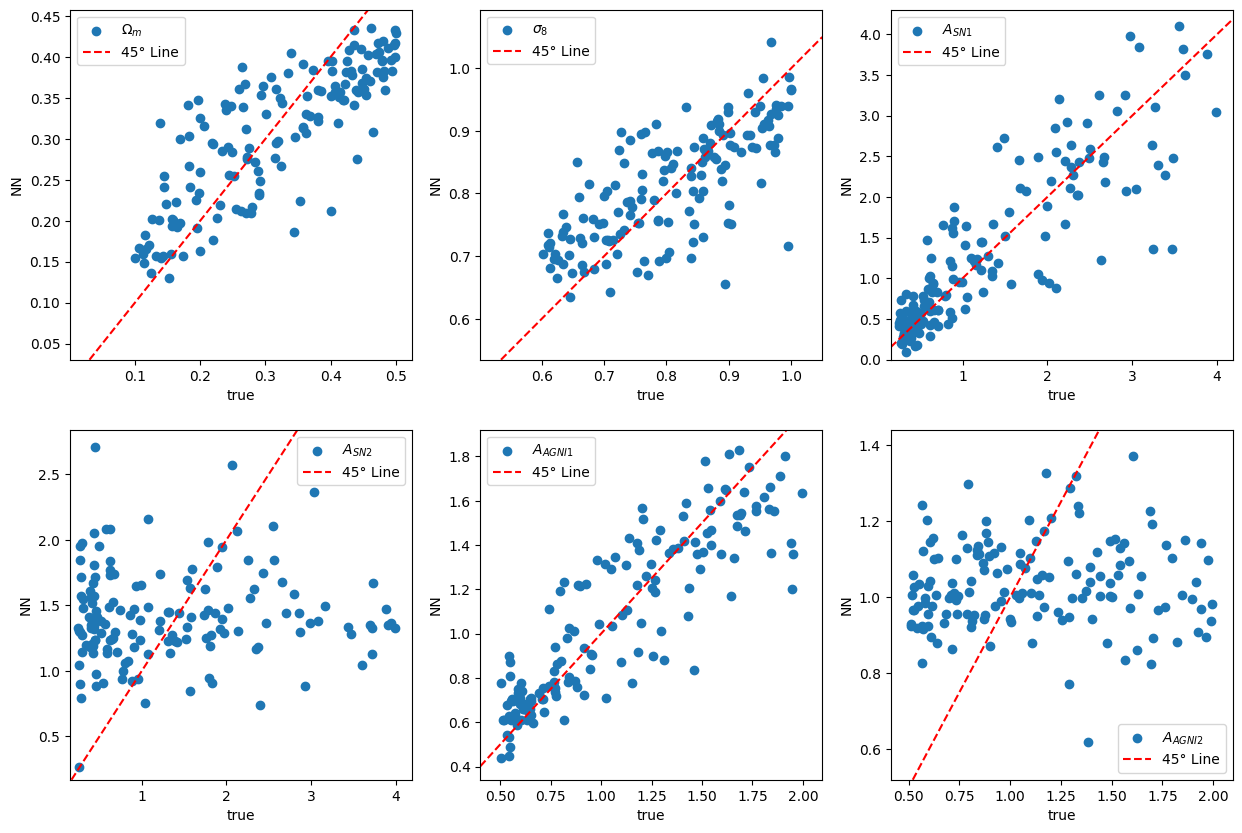

come si vede il Neural network riesce ad approssimare soltanto i parametri  $ \vec{\theta}_1=\{ \Omega_m, \sigma_8,A_{SN1},A_{AGNI1}\}   $ mentre i parametri  $ \vec{\theta}_2=\{ A_{SN2},A_{AGNI2}\}   $ sembrano distribuiti ad occhio in modo completamente casuale.

presupposto che l'argoritmo di training funzioni correttamente, queste risultato indica una correlazione molto debole tra $ \vec{\theta}_2 $ e $ SFRD $.

il NN non può inferire risultati più precisi dei dati sperimentali, questo spiega anche perche la `loss_function` non va mai sotto 0.5:  il NN possiede un **lower-bound** sulla `loss-function` dato dalla incertezza dei dati.

qui sotto mostro una triangular plot dei parametri predetti dal NN:

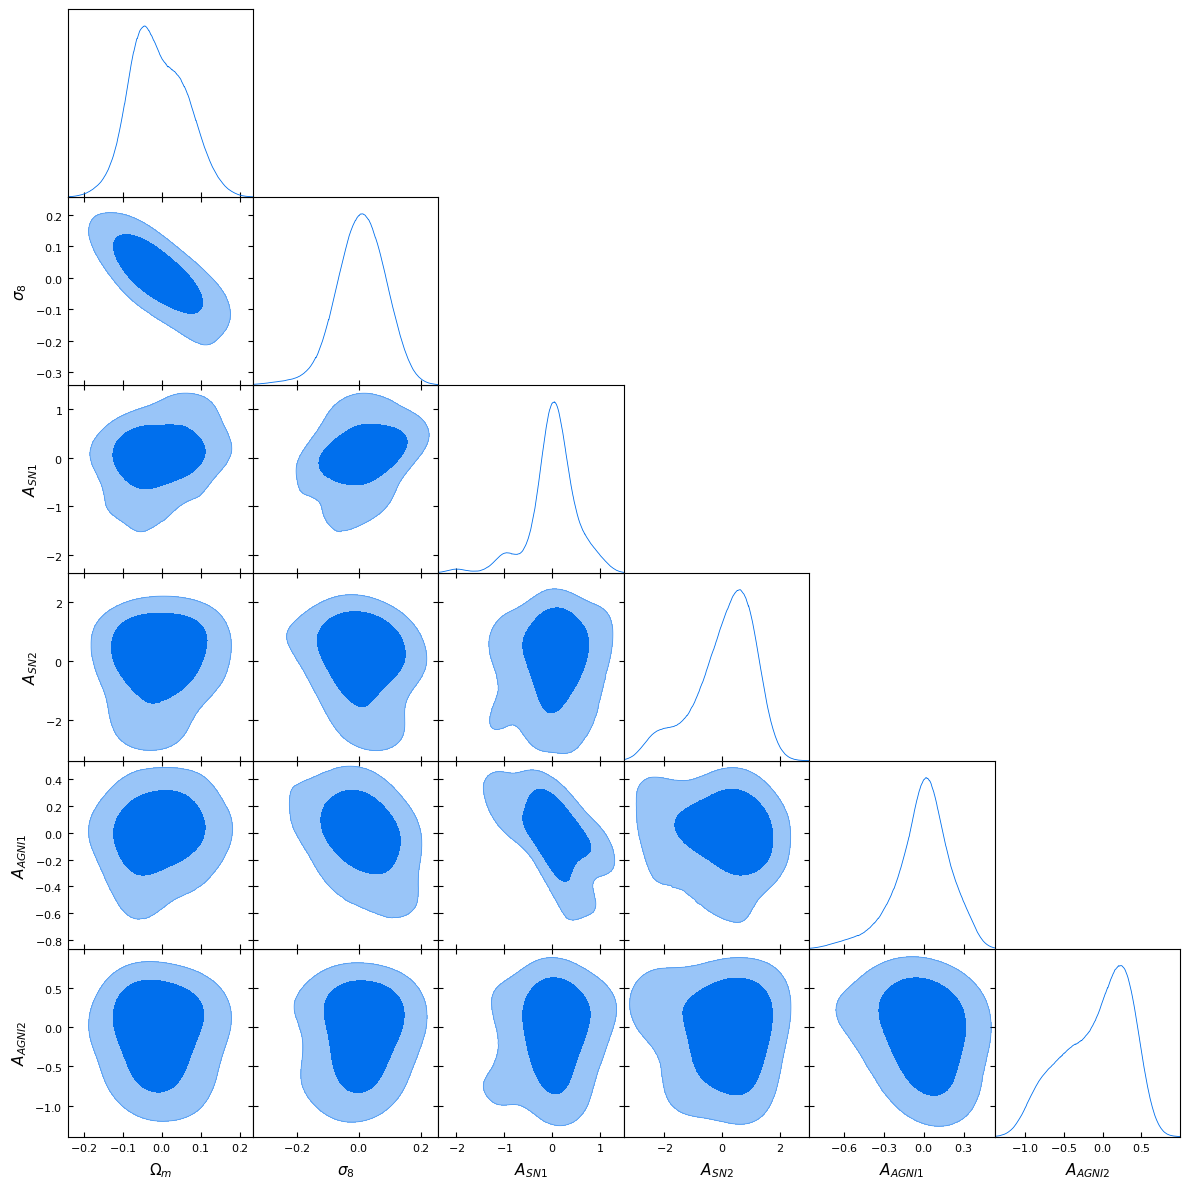

qui mostri l'istrogramma dei valori assuliti dell'errore qui parametri, l'asse verticale invece mostra la stimata su questa risultati:
$$ Δ\vecθ=|\vecθ_{vero}-\vecθ_{NN} | \quad \text{,}\quad σ^2=\frac{1}{n}∑Δθ_i^2 $$

che utilizzero come confronto per il punto successivo

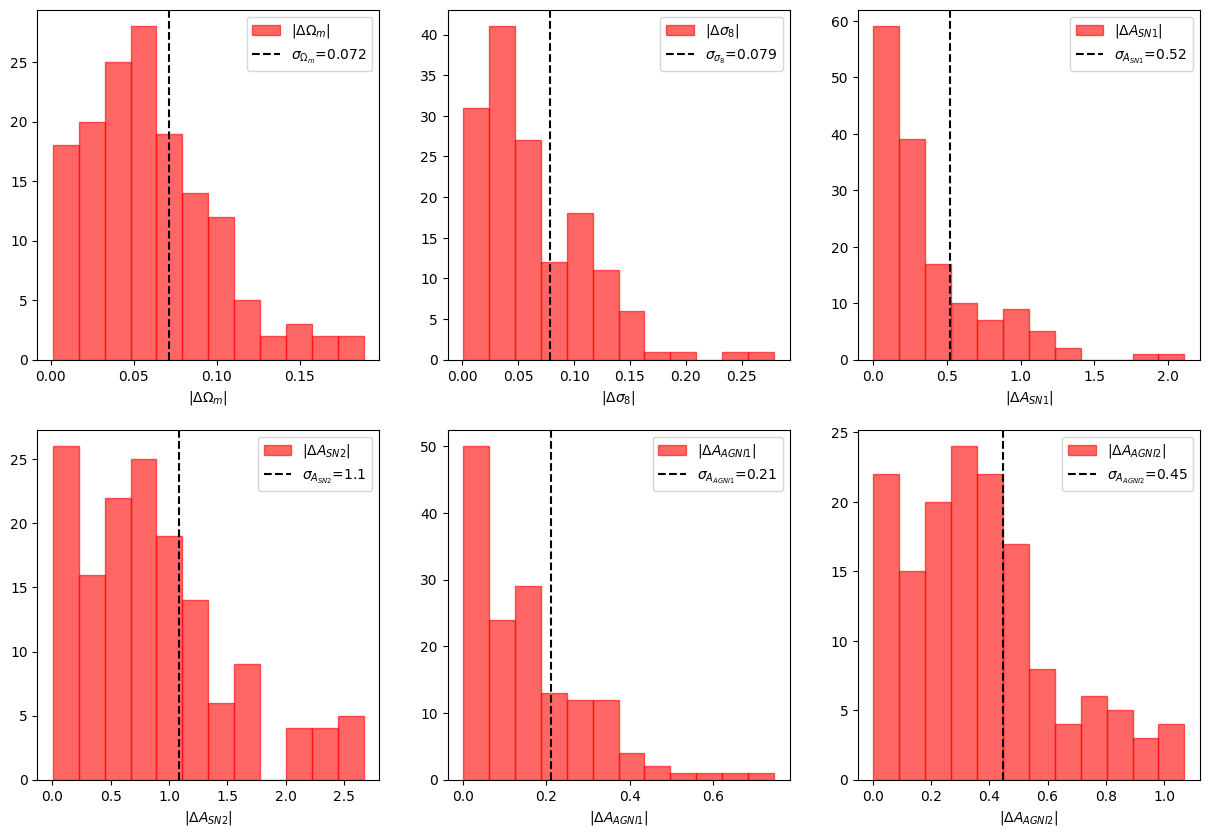

### Errori con la loss function

questi risultati sono stati creati usando i miglior parametri suggeriti da Optuna.
```
number_layers: 3
learning_rate: 0.002627160214746434
epochs: 337
hidden_size: 68
```

come prima qui sotto mostro il plot delle loss in funzione delle epoche, si vede che il NN raggiunge un plateau quasi immediatamente, questo potrebbe essere risultato da diversi fattori:
1. i dati delle simulazioni non possiedono correlazioni ovvi tra input e output
2. la loss function che ora è un Logaritmo porta spesso un training più veloce della media-quadratica

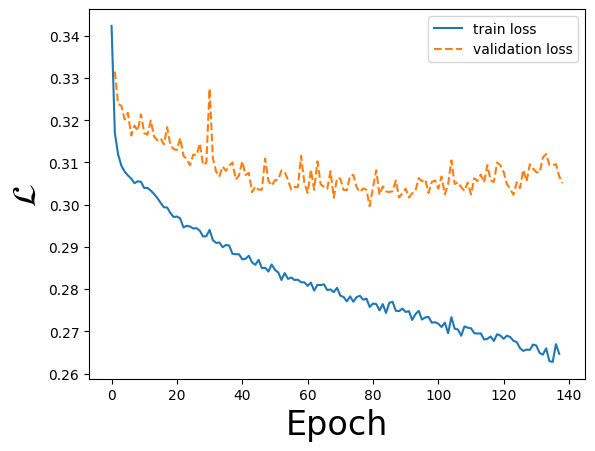

Qui in seguito mostro uno Scatteplot con errori predetti dal Neural Network rispetto ai valori veri.

anche questo secondo NN mostra che i parametri $\vecθ_2$ hanno una distribuzione praticamente casuale, mentre gli errori sembrano ad occhio rispecchiare la varianza effetiva dei risultati.

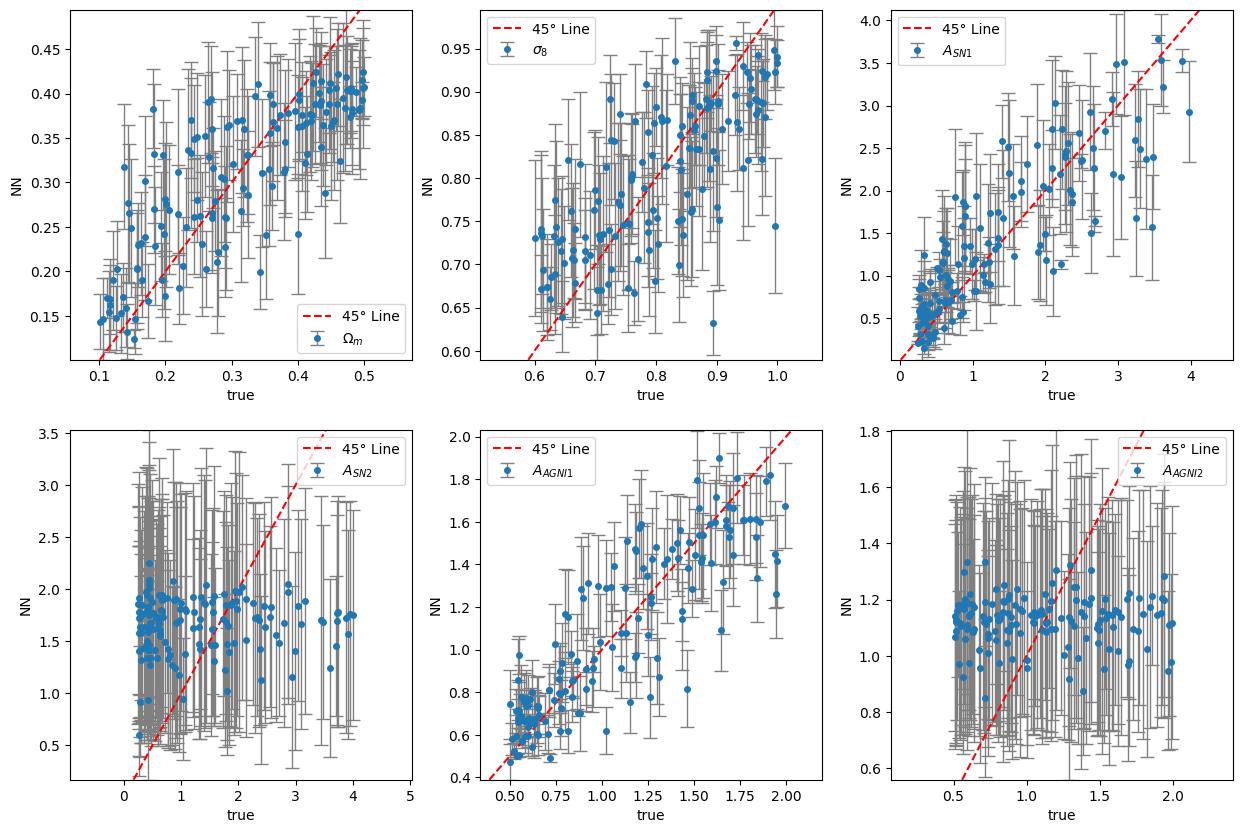

questi istogrammi mostrano la distribuziione dei delle varianze predetta e l'asse verticale mostra il loro valore medio, confrontando il $σ_{medio}$ in questo caso e $\sigma_{stima}$ trovato precendentemente si vede che hanno la stessa ordine di grandezza.

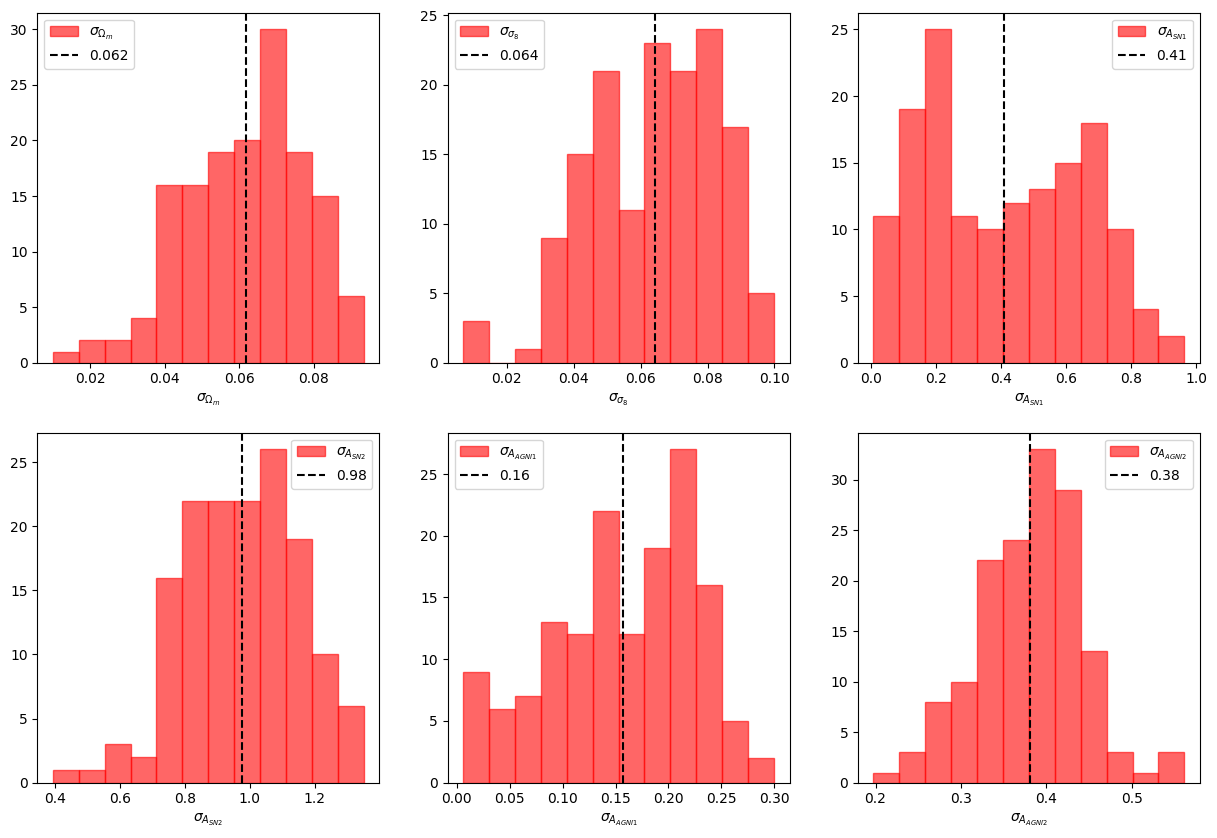

## Conclusioni

dato i risultati del NN possiamo concludere che i 2 parametri $ \vec{\theta}_2=\{ A_{SN2},A_{AGNI2}\}$ hanno un influenza trascurabile sull'evoluzione temporale della **SFRD**.

Gli altri parametri $ \vec{\theta}_1=\{ \Omega_m, \sigma_8,A_{SN1},A_{AGNI1}\}   $, possiedono una incertezza intrinseca che può essere causato da diversi fattori:
1. Mancanza di dati, è possibile che 100 punti della funzione $ sfrd(z,\vec\theta)$ non siano abbastanza per definire in modo univoco i parametri, in questo caso l'aumentare il numeri di dati dovrebbe migliorare la stime dei parametri
2. Modello errato, è possibile che la star-formation-density-rate $sfrd(z,\vec\theta)$ dipenda da ulteriori parametri oltre alle 6 dei dati, quindi 2 set identici di $\{\theta\}$ protrebbero dare 2 funzioni completamente diverse e 2 set diversi potrebbero dare la stessa funzione, in questo caso ci sarebbe un limite inferiore sulla precisione delle stime su qualunque quantità di dati.
3. Altro 